In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Trainig process...
Test process...
225/225 [==============================] - 1s 3ms/step - loss: 2.9600 - accuracy: 0.5644
Test loss: 2.9600303173065186
Test accuracy: 56.436336040496826


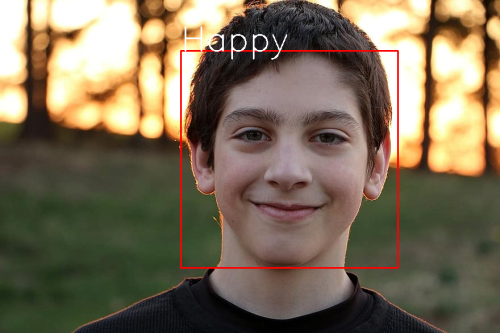

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Aug  8 21:58:51 2020

@author: luismiguells
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from keras import utils, optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from keras.preprocessing import image
from google.colab.patches import cv2_imshow # Remove this line in case you're not in a Google Colab environment


# Required files
# main_dir = "/Users/luismiguells/Documents/RN/source/project/data/"
main_dir = "/content/drive/My Drive/project/data/"
data_file = main_dir+'fer2013.csv'
cascade_file = main_dir+"haarcascade_frontalface_default.xml"
test_img = main_dir+"image_1.jpg"


# Variables
num_classes = 7 # Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral
batch_size = 256
epochs = 50 # In case you're not in a Google Colab environment use less than 10

# Read the dataset and create Numpy arrays to storage the information 
data = pd.read_csv(data_file)

label, pixels, usage = list(data["emotion"]), list(data["pixels"]), list(data["Usage"])

x_train, y_train, x_test, y_test = [], [], [], []

for emo, im, usg in zip(label, pixels, usage):
    im = im.split(" ")
    img = np.array(im, "float32")
    emotion = utils.to_categorical(emo, num_classes)
    
    if "Training" == usg:
        x_train.append(img)
        y_train.append(emotion)
    else:
        x_test.append(img)
        y_test.append(emotion)


# Transform the data in a proper format
x_train = np.array(x_train, "float32")
y_train = np.array(y_train, "float32")
x_test = np.array(x_test, "float32")
y_test = np.array(y_test, "float32")

# Normalize the data
x_train /= 255 
x_test /= 255


# Reshape the data to create an array of arrays of 48x48
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype("float32")
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype("float32")

# Creation of the neural network
model = Sequential()

# First layer
model.add(Conv2D(64, (5, 5), activation="relu", input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

# Second layer
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

# Third layer
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Flatten())

# Fully connected NN for classification
model.add(Dense(1024, activation="relu"))
model.add(Dense(1024, activation="relu"))

# Layer of classification
model.add(Dense(num_classes, activation="softmax"))

#Compile the model (neural network)
model.compile(loss="categorical_crossentropy"
    ,optimizer=optimizers.Adam()
    ,metrics=["accuracy"]
    )

# Train the neural network
print("Trainig process...")
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0) # In case you want to see the progress set verbose=1

# Evaluation
print("Test process...")
test_score = model.evaluate(x_test, y_test)
print("Test loss:", test_score[0])
print("Test accuracy:", 100*test_score[1])

# Use a cascade classifer to detect only detect the faces in the image
face_cascade = cv2.CascadeClassifier(cascade_file)
read_img = cv2.imread(test_img)
gray = cv2.cvtColor(read_img, cv2.COLOR_BGR2GRAY) 
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# Find all possible faces in the test image and draw a rectangle when found
for (x, y, w, h) in faces:
    # Draw the rectangle
    cv2.rectangle(read_img, (x, y), (x+w,y+h), (0,0,255), 2)

    # With the detect face crop it, transform it to gran sacle and resize 
    detected_face = read_img[int(y):int(y+h), int(x):int(x+w)] 
    detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY) 
    detected_face = cv2.resize(detected_face, (48, 48)) 

    # Convert the detect face to and array and flat it
    img_pixels = image.img_to_array(detected_face)
    img_pixels = np.expand_dims(img_pixels, axis = 0)

    # Normalize
    img_pixels /= 255
    
    # Make the predictions with the trained model
    predictions = model.predict(img_pixels)

    # Find the max value that represent the best prediction
    max_index = np.argmax(predictions[0])

    # Select one of the emotions
    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    emotion = emotions[max_index]

    # Write the emotion name in the upper left corner of the rectangle
    cv2.putText(read_img, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)

# Find the dimension of the image to display it in a proper size
height, width = read_img.shape[:2]

# Set maximum values 
max_height = 500
max_width = 500

# Only shrink the image if is bigger than required
if max_height < height or max_width < width:
    # Get the scaling factor
    scaling_factor = max_height / float(height)
    if max_width/float(width) < scaling_factor:
        scaling_factor = max_width / float(width)
    # Resize the image
    read_img = cv2.resize(read_img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)

cv2_imshow(read_img) # Use cv2.imshow() in case you're not in a Google Colab environment